In [2]:
# loading libraries
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import plotly.graph_objects as graph
import itertools
from plotly.subplots import make_subplots
from tensorflow.keras import layers,Input,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,Input, AveragePooling2D,BatchNormalization,Activation,ZeroPadding2D,concatenate,Add
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session,get_value,set_value
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import sys
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard,LearningRateScheduler,EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow import keras
import keras_tuner as kt


from IPython.display import Image
import os
import cv2
import warnings
#%matplotlib inline 
#print(os.listdir("c:/Users/user/Desktop"))
warnings.filterwarnings("ignore")
fault_mapping = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','None']
from preparing import savefile,loadfile,acc_plot,core_select
from preparing import confusion_matrix_display,remove_unwanted_x,OnehotX
#print(device_lib.list_local_devices())
core_select('GPU')
#import shutil
#shutil.rmtree('my_log', ignore_errors=True)
tensorboard = TensorBoard(log_dir='my_log')
#Run command at terminal: tensorboard --logdir=G:\我的雲端硬碟\Colab_Notebooks\WAFER\Program\my_log 
#Check tensorboard at "http://localhost:6006/
#Reference : https://docs.pythontab.com/tensorflow/how_tos/summaries_and_tensorboard/
waferSizeX=48
waferSizeY=48
#filename='dbscan'
#filename='split'
filename='dbscan'
if filename=='split':
    chartname='Org'
elif filename=='dbscan':
    chartname='DBSCAN'
elif filename=='autoencoder':
    chartname='Auto Encoder'
orgx_train,orgy_train=loadfile('%s_train_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
orgx_test,orgy_test=loadfile('%s_test_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
orgx_verify,orgy_verify=loadfile('%s_verify_onehot%s_%s'%(filename,waferSizeX,waferSizeY))
np.set_printoptions(threshold=80)
print('train_x_shape:%s'%str(orgx_train.shape))
print('train_y_shape:%s'%str(orgy_train.shape))
print('test_x_shape:%s'%str(orgx_test.shape))
print('test_y_shape:%s'%str(orgy_test.shape))
print('verify_x_shape:%s'%str(orgx_verify.shape))
print('verify_y_shape:%s'%str(orgy_verify.shape))

File Load:dbscan_train_onehot48_48
File Load:dbscan_test_onehot48_48
File Load:dbscan_verify_onehot48_48
train_x_shape:(24336, 48, 48, 3)
train_y_shape:(24336, 8)
test_x_shape:(3479, 48, 48, 3)
test_y_shape:(3479, 8)
verify_x_shape:(6955, 48, 48, 3)
verify_y_shape:(6955, 8)


# MACRO & MODELS

In [9]:
from models import cnn,LeNet,AlexNet,vgg16,Resnet18,Resnet50,googLeNet
#from models import hypercnn
#===================================
#================
def loaddata():
#================    
    return orgx_train,orgy_train,orgx_test,orgy_test,orgx_verify,orgy_verify
#================
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
#================
#cm:混淆矩阵值
#classes:分类标签
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('%s Confusion Matrix'%title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j]!=0:
            plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black") #,bbox=(dict(facecolor='white')))
#    plt.grid()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./report_chart/%s_CM.jpg'%title, bbox_inches='tight', dpi=150)
    return
#================
def report_confustion_matrix(x_test,y_test,title,plottitle,batch_size=128,use_mini_batch=False):
#================
    clear_session()
    model = load_model('./trained_model/%s_Model.h5'%title)
    if use_mini_batch==True:
        total=(len(y_test)//batch_size)*batch_size
        nx_test=x_test[:total]
        y_test=y_test[:total]
        Y_pred = model.predict_generator(generator=mini_batchX(nx_test,batch_size),steps=len(x_test)//batch_size)
    else:
        Y_pred = model.predict(x=x_test,batch_size=batch_size)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test=y_test.argmax(1)
    #print(confusion_matrix(y_test, y_pred))
    cm=confusion_matrix(y_test, y_pred,normalize='true')
    cm=np.round(cm,decimals=2)
    plot_confusion_matrix(cm=cm,classes=fault_mapping[:8],title=plottitle)    
#    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=fault_mapping[:8])
#    disp.plot(xticks_rotation=45,cmap=plt.cm.Blues)
#    plt.title('%s Confusion Matrix'%plottitle)
#    plt.tight_layout()
#    plt.savefig('./report_chart/%s_CM.jpg'%plottitle, bbox_inches='tight', dpi=150)
#    plt.show()
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='./report_chart/%s_Model.png'%title)
    print('Classification Report')
    table=classification_report(y_test, y_pred, target_names=fault_mapping[:8])
    print(table)
#    col=[1]
#    row=[2]
#    plt.figure(figsize=(20,5))
#    tab=plt.table(cellText=table[0],colLabels=col,rowLabels=row,loc='center',cellLoc='center',rowLoc='center')
#    tab.scale(1,1)
#    plt.axis('off')
    return

#==================
def hyper_acc_plot(title_a,title_b,savename,thistory):
#==================   
    #transfer to %
    acc_list=[]
    val_acc_list=[]
    loss_list=[]
    val_loss_list=[]
    for i in thistory.history['accuracy']:
        acc_list.append(i*100)
    for i in thistory.history['val_accuracy']:
        val_acc_list.append(i*100)
    for i in thistory.history['loss']:
        loss_list.append(i*100)
    for i in thistory.history['val_loss']:
        val_loss_list.append(i*100)
    
    temp=len(thistory.history['accuracy'])
    xtick_index=int(temp//10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    #fig.suptitle('A tale of 2 subplots')
    ax1.plot(acc_list)
    ax1.plot(val_acc_list)
    ax1.set_title(title_a,fontweight="bold", size=20)
    ax1.set_ylabel('accuracy %',fontsize=12)
    ax1.set_xlabel('epoch',fontsize=12)
    ax1.legend(['train', 'test'], loc='upper left')
    ax1.set_ylim([0,110])
    ax1.autoscalex_on=0
    ax1.set_yticks(list(range(0,110,10)))
    ax1.set_xticks(list(range(0,len(thistory.history['accuracy']),xtick_index)))
    ax1.set_xticklabels(list(range(1,len(thistory.history['accuracy'])+1,xtick_index)))
    ax1.grid()
    
    ax2.plot(loss_list)
    ax2.plot(val_loss_list)
    ax2.set_title(title_b,fontweight="bold", size=20)
    ax2.set_ylabel('loss %',fontsize=12)
    ax2.set_xlabel('epoch',fontsize=13)
    ax2.legend(['train', 'test'], loc='upper right')
    ax2.set_ylim([0,110])
    ax2.autoscalex_on=0
    ax2.set_yticks(list(range(0,110,10)))
    ax2.set_xticks(list(range(0,len(thistory.history['val_accuracy']),xtick_index)))
    ax2.set_xticklabels(list(range(1,len(thistory.history['val_accuracy'])+1,xtick_index)))
    ax2.grid()
    
    fig.savefig('./report_chart/%s.jpg'%savename, bbox_inches='tight', dpi=150)
    plt.show()
    return

# Hyper CNN

In [6]:
hp = kt.HyperParameters()
#===================
def hypercnn(hp):
#===================
    loss='categorical_crossentropy'
    rates1 = hp.Float('rate1', min_value=0.2, max_value=0.4, step=0.05)  # Autotune 1 dropout
    rates2 = hp.Float('rate2', min_value=0.2, max_value=0.4, step=0.05)  # Autotune 2 dropout
    rates3 = hp.Float('rate3', min_value=0.2, max_value=0.4, step=0.05)  # Autotune 3 dropout
    rates4 = hp.Float('rate4', min_value=0.2, max_value=0.4, step=0.05)  # Autotune 4 dropout
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=32)   #
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)   #
    hp_units3 = hp.Int('units3', min_value=256, max_value=1024, step=32) #
    model = Sequential()
    model.add(Conv2D(hp_units1, (3, 3), activation='relu', padding='same',input_shape=(48,48, 3)))  					# 卷積層 (輸入)
    model.add(Dropout(rates1))           							    # Dropout
    model.add(MaxPooling2D((2, 2)))                        			    # 池化層
    model.add(Conv2D(hp_units2, (3, 3), padding='same', activation='relu'))  # 卷積層
    model.add(Dropout(rates2))                              			# Dropout 層
    model.add(MaxPooling2D((2, 2)))                             		# 池化層
    model.add(Flatten())                                    			# 展平層
    model.add(Dropout(rates3))                                   		# Dropout
    model.add(Dense(hp_units3, activation='relu'))                      # 密集層
    model.add(Dropout(rates4))                                     	    # Dropout
    model.add(Dense(8, activation='softmax'))                    		# 密集層 (輸出分類)
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  #learning rate 調整
    model.compile(optimizer=Adam(learning_rate=1e-3),loss=loss,metrics=['accuracy'])
    return model  
epochs=50
verbose=1
batch_size=128
#def build_model(x_train,y_train,x_verify,y_verify,model,savename,batch_size=128,epochs=100,verbose=1,use_mini_batch=False,loss='categorical_crossentropy',optimizer=Adam(decay=default_decay_lr),plottitle='')
x_train,y_train,x_test,y_test,x_verify,y_verify=loaddata()
clear_session()
tuner = kt.Hyperband(hypercnn,objective='val_accuracy',max_epochs=10,factor=3,directory='my_dir',project_name='HyperCNN_%s'%filename)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
tuner.search(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs,verbose=verbose, callbacks=[stop_early])    
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
#history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)
mhistory = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=batch_size,epochs=epochs,verbose=verbose)

val_acc_per_epoch = mhistory.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)
#Retrain the model
hhistory=hypermodel.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=batch_size,epochs=best_epoch,verbose=verbose,callbacks=[tensorboard])   
model.summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir\HyperCNN_dbscan\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\HyperCNN_dbscan\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
191/191 [==============================] - 14s 53ms/step - loss: 0.6611 - accuracy: 0.7690 - val_loss: 0.4093 - val_accuracy: 0.8732
Epoch 2/50
191/191 [==============================] - 10s 51ms/step - loss: 0.3334 - accuracy: 0.8689 - val_loss: 0.3225 - val_accuracy: 0.8985
Epoch 3/50
191/191 [==============================] - 10s 52ms/step - loss: 0.2772 - accuracy: 0.8931 - val_loss: 0.3332 - val_accuracy: 0.8977
Epoch 4/50
191/191 [==============================] - 10s 51ms/step - loss: 0.2472 - accuracy: 0.9036 - val_loss: 0.2571 - val_accuracy: 0.9161
Epoch 5/50
191/191 [==============================] - 10s 50ms/step - loss: 0.2144 - accuracy: 0.9168 - val_loss: 0.2291 - val_accuracy: 0.9218
Epoch 6/50
191/191 [==============================] - 10s 50ms/step - loss: 0.19

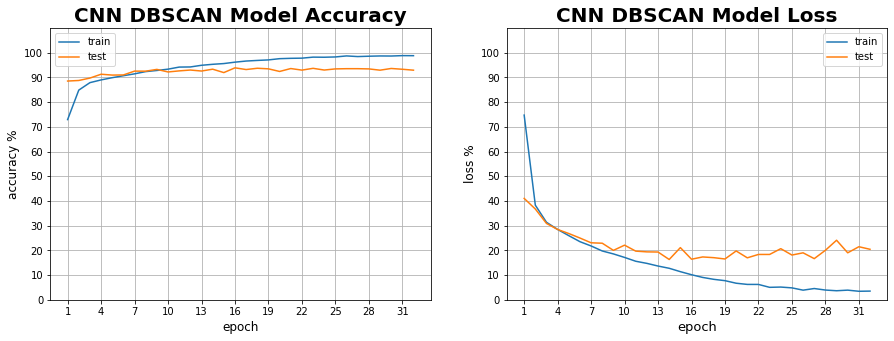

In [10]:
hyper_acc_plot('CNN %s Model Accuracy'%chartname, 'CNN %s Model Loss'%chartname,savename, hhistory)

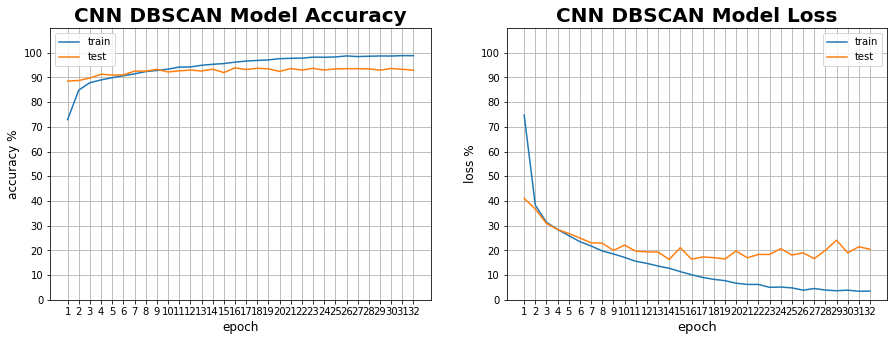

Classification Report
              precision    recall  f1-score   support

      Center       0.98      0.97      0.97      1000
       Donut       0.94      0.98      0.96       727
    Edge-Loc       0.89      0.94      0.91       999
   Edge-Ring       0.96      0.98      0.97       999
         Loc       0.94      0.84      0.89       999
      Random       0.96      0.98      0.97      1000
     Scratch       0.93      0.92      0.92       999
   Near-full       0.95      0.99      0.97       232

    accuracy                           0.94      6955
   macro avg       0.94      0.95      0.95      6955
weighted avg       0.94      0.94      0.94      6955



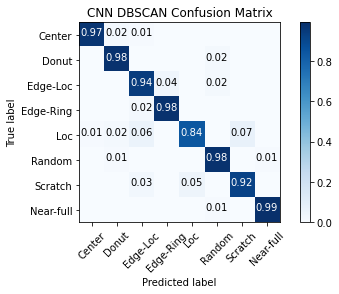

In [7]:
savename='CNN_%s'%filename
hyper_acc_plot('CNN %s Model Accuracy'%chartname, 'CNN %s Model Loss'%chartname,savename, hhistory)
model.save('./trained_model/%s_Model.h5'%savename)
model.save_weights('./trained_model/%s_weights.h5'%savename)
report_confustion_matrix(x_verify,y_verify,'CNN_%s'%filename,plottitle='CNN %s'%chartname)
#Image(retina=True, filename='./report_chart/CNN_%s_Model.png'%filename)

In [4]:
savename='CNN_%s'%filename
model=load_model('./trained_model/%s_Model.h5'%savename)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 144)       4032      
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 144)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 144)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       332032    
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                  

In [24]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 48, 48, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_2_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_2',
    'trainable': True,
    'batch_input_shape': (None, 48, 48, 3),
    'dtype': 'float32',
    'filters': 144,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_4',
    'trainable': True,
    'dtype